# Fit emimTF2N data

EoS: PR

Parameter T dependence: Constant

N (total fitting parameters): 2

## Import Functions

In [1]:
import idaes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import sys
sys.path.append('../../')

from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)
from pyomo.opt import TerminationCondition, SolverStatus

from idaes.core import FlowsheetBlock
import idaes.logger as idaeslog
# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)
# Import unit models from the model library
from idaes.generic_models.unit_models import Flash
# Import degrees of freedom tool
from idaes.core.util.model_statistics import degrees_of_freedom

# parmest (binary_param2)
from bip_fitting_functions import constant

import scipy.stats as stats

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches

## Load Data

In [2]:
data_full = pd.read_csv('r32_emimtf2n_full.csv')
data_subset = pd.read_csv('r32_emimtf2n_subset.csv')

In [3]:
data_full

,temperature,pressure,x_R32,x_emimTf2N
0,283.15,10200,0.014,0.986
1,283.15,100100,0.136,0.864
2,283.15,250300,0.306,0.694
3,283.15,399300,0.448,0.552
4,283.15,549300,0.570,0.430
5,283.15,700400,0.672,0.328
6,283.15,849400,0.786,0.214
7,298.15,9600,0.010,0.990
8,298.15,99800,0.095,0.905
9,298.15,250200,0.218,0.782


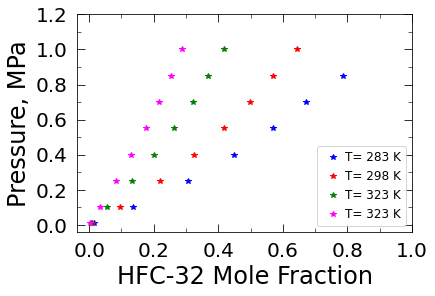

In [4]:
fig, ax = plt.subplots()

ax.plot(data_full["x_R32"][:7],data_full["pressure"][:7]/1e6,"*",color='blue',label="T= 283 K")
ax.plot(data_full["x_R32"][7:15],data_full["pressure"][7:15]/1e6,"*",color='red',label="T= 298 K")
ax.plot(data_full["x_R32"][15:23],data_full["pressure"][15:23]/1e6,"*",color='green',label="T= 323 K")
ax.plot(data_full["x_R32"][23:],data_full["pressure"][23:]/1e6,"*",color='magenta',label="T= 323 K")

# plt.title('Isotherm R32-[emim][TF2N]')
ax.set_ylabel('Pressure, MPa',fontsize=24)
ax.set_xlabel('HFC-32 Mole Fraction',fontsize=24)

ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9],minor=True)
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
ax.set_yticks([0.1, 0.3, 0.5, 0.7, 0.9, 1.1],minor=True)

ax.tick_params("both", direction="in", which="both", length=4, labelsize=20, pad=10)
ax.tick_params("both", which="major", length=8)
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")

ax.legend(fontsize=12, handletextpad=0.00, loc="lower right")#, bbox_to_anchor=(1, 0.5))
fig.savefig('R32-emimTF2N-data.pdf',bbox_inches='tight')
plt.show()

## Load Configuration + Check DOF

In [5]:
from hfc32_emimtf2n_PR import configuration 

In [6]:
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})
m.fs.properties = GenericParameterBlock(default=configuration)
m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})
DOF_initial = degrees_of_freedom(m)
print('The initial DOF is {0}'.format(DOF_initial))

The initial DOF is 7


## Fit Parameters

### Multistart Results

In [7]:
lhs = pd.read_csv('Data/Fits/LHS_Fits/PR_noTdep_LHS.csv',usecols=[1,2,3,4,5,6,7])

In [8]:
lhs

,Param1,Param2,sc_param1,sc_param2,"PR_kappa_A[emimTf2N,R32]","PR_kappa_A[R32,emimTf2N]",SSR
0,0.590628,0.473396,0.182644,-0.050080,NaN,NaN,NaN
1,0.092421,0.219843,-0.820063,-0.558984,NaN,NaN,NaN
2,0.381983,0.343458,-0.237280,-0.310878,NaN,NaN,NaN
3,0.053751,0.659045,-0.897890,0.322534,NaN,NaN,NaN
4,0.396843,0.776563,-0.207374,0.558402,NaN,NaN,NaN
...,...,...,...,...,...,...,...
245,0.193044,0.943144,-0.617546,0.892747,NaN,NaN,NaN
246,0.226503,0.065894,-0.550206,-0.867972,NaN,NaN,NaN
247,0.704096,0.717333,0.411012,0.439524,NaN,NaN,NaN
248,0.275859,0.754164,-0.450869,0.513446,NaN,NaN,NaN


In [9]:
lhs_final = lhs.dropna(axis=0).reset_index()

In [10]:
lhs_final

,index,Param1,Param2,sc_param1,sc_param2,"PR_kappa_A[emimTf2N,R32]","PR_kappa_A[R32,emimTf2N]",SSR
0,51,0.391852,0.457130,-0.217418,-0.082728,-0.200947,-0.056196,0.652664
1,78,0.353657,0.455589,-0.294291,-0.085820,-0.200947,-0.056196,0.652664


In [ ]:
lhs_final['sc_param1'][0]

## Apply Parameters + Plot

In [11]:
parameters, obj_value, a = constant(data_subset, configuration, 'R32', 'emimTf2N', "x_R32", "x_emimTf2N", 
    init_temp =  283.1, init_press =   399300 , init_x_c1 =    0.448, init_x_c2 = 0.552,
    init_kappa_A_2_1 = -0.29429130099451073, init_kappa_A_1_2 = -0.08582014684000472, eps = 0.1, scaling_fac = 1e-9 , read=False, filename='PR_noTdep_final_ipopt.txt')

2022-05-12 12:48:53 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-05-12 12:48:54 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-05-12 12:48:54 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-05-12 12:48:55 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-05-12 12:48:55 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-05-12 12:48:55 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-05-12 12:48:56 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-05-12 12:48:56 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-05-12 12:48:57 [INFO] idaes

/Users/bridgettebefort/opt/anaconda3/envs/idaes-pse-dev/lib/python3.9/site-packages/pyomo/contrib/interior_point/interface.py:418: RuntimeWarning: divide by zero encountered in true_divide
  data = (duals_primals_lb/(primals - self._nlp.primals_lb()) +


In [12]:
print('Objective (SSE):',obj_value)

Objective (SSE): 0.6526637302412922


In [13]:
print('Parameters:',parameters)

Parameters: fs.properties.PR_kappa_A[emimTf2N,R32]   -0.200947
fs.properties.PR_kappa_A[R32,emimTf2N]   -0.056196
dtype: float64


In [14]:
cov = np.array(a)
print('Covariance Matrix:')
print(cov)

Covariance Matrix:
[[3.66990409e-04 3.31181344e-05]
 [3.31181344e-05 4.59347392e-06]]


In [15]:
np.savetxt('Data/Covariance/PR_Cov_2parameter.csv',cov,delimiter=',')

In [16]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [17]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.5)

m.fs.properties.PR_kappa_A['R32','emimTf2N'] = parameters['fs.properties.PR_kappa_A[R32,emimTf2N]']
m.fs.properties.PR_kappa_A['emimTf2N','R32'] = parameters['fs.properties.PR_kappa_A[emimTf2N,R32]']

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].unfix()

R32_x = np.zeros((len(data_full)))
P = np.zeros((len(data_full)))

m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)

for i in range(len(data_full)):
    m.fs.liq = data_full["x_emimTf2N"].iloc[i]
    m.fs.F101.inlet.temperature.fix(float(data_full["temperature"].iloc[i]))
    m.fs.F101.inlet.pressure.fix(float(data_full["pressure"].iloc[i]))
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(data_full["x_R32"].iloc[i])+0.1)
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(data_full["x_R32"].iloc[i]+0.1)))
    m.fs.F101.vap_outlet.temperature.fix(float(data_full["temperature"].iloc[i]))
    
#     DOF_final = degrees_of_freedom(m)
#     print("The final DOF is {0}".format(DOF_final))
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
    
    status = solver.solve(m, tee = False)

#     m.fs.F101.report()
    if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
        print(data_full["x_emimTf2N"].iloc[i])
        R32_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
        P[i] = value(m.fs.F101.vap_outlet.pressure[0])

    else:
        print('Infeasible.')

0.986
0.864
0.694
0.552
0.43
0.328
0.214
0.99
0.905
0.782
0.675
0.583
0.501
0.43
0.357
0.995
0.945
0.867
0.8
0.736
0.68
0.632
0.583
0.998
0.966
0.916
0.869
0.825
0.784
0.746
0.712


In [18]:
fitted_data = pd.DataFrame(data=[R32_x,P/1e6])
fitted_data = fitted_data.T
fitted_data.columns = ['R32_x','P, MPa']
fitted_data.to_csv('Data/Fits/PR_FittedData_2parameter.csv')

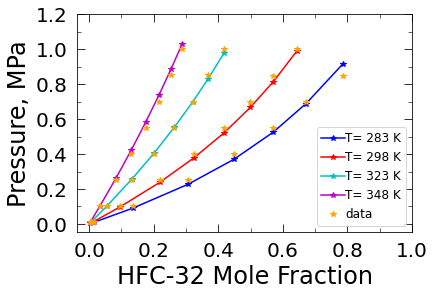

In [19]:
P1= np.zeros((len(P)))

for i in range(len(P)):
    P1[i] = P[i]/1e6

fig, ax = plt.subplots()

ax.plot(R32_x[0:7],P1[0:7],"b*-",label="T= 283 K")  
ax.plot(R32_x[7:15],P1[7:15],"r*-",label="T= 298 K") 
ax.plot(R32_x[15:23],P1[15:23],"c*-",label="T= 323 K") 
ax.plot(R32_x[23:31],P1[23:31],"m-*",label="T= 348 K")
ax.plot(data_full["x_R32"],data_full["pressure"]/1e6,"*",color='orange',label="data")  

# plt.title('Isotherm R32-[emim][TF2N]')
ax.set_ylabel('Pressure, MPa',fontsize=24)
ax.set_xlabel('HFC-32 Mole Fraction',fontsize=24)

ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9],minor=True)
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
ax.set_yticks([0.1, 0.3, 0.5, 0.7, 0.9, 1.1],minor=True)

ax.tick_params("both", direction="in", which="both", length=4, labelsize=20, pad=10)
ax.tick_params("both", which="major", length=8)
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")

ax.legend(fontsize=12, handletextpad=0.00, loc="lower right")#, bbox_to_anchor=(1, 0.5))
fig.savefig('R32-emimTF2N-noTdep.pdf',bbox_inches='tight')
plt.show()

### Print Eigvals, Eigvectors of Covariance

An identifiability analysis can be performed with these as well as a FIM because the covariance matrix is the inverse of the FIM. That means that if there are any eigvals >> 0, their eigvecs indicate directions of un-identifiability.

In [20]:
cov = np.array(a)
print('Covariance Matrix:')
print(cov)

Covariance Matrix:
[[3.66990409e-04 3.31181344e-05]
 [3.31181344e-05 4.59347392e-06]]


In [21]:
eigvals, eigvecs = np.linalg.eig(cov)

In [22]:
eigvals

array([3.69992092e-04, 1.59179092e-06])

In [23]:
eigvecs

array([[ 0.99591773, -0.09026563],
       [ 0.09026563,  0.99591773]])

In [24]:
np.savetxt('Data/EigenAnalysis/PR_vals_2parameter.csv',eigvals,delimiter=',')
np.savetxt('Data/EigenAnalysis/PR_vecs_2parameter.csv',eigvecs,delimiter=',')

In [25]:
FIM = np.linalg.inv(cov) 

#A_opt
FIM_trace = np.trace(FIM)
cov_trace = np.trace(cov)

#D_opt
FIM_det = np.linalg.det(FIM)

#E_opt
eigvals_FIM, eigvecs_FIM = np.linalg.eig(FIM)
eigvals_FIM_min = eigvals_FIM.min()

np.savetxt('Data/EigenAnalysis/PR_FIMtrdet_2parameter.csv',[cov_trace,FIM_trace,FIM_det,eigvals_FIM_min])
np.savetxt('Data/EigenAnalysis/PR_FIMvals_2parameter.csv',eigvals_FIM,delimiter=',')
np.savetxt('Data/EigenAnalysis/PR_FIMvecs_2parameter.csv',eigvecs_FIM,delimiter=',')

In [26]:
FIM

array([[  7799.42865739, -56232.50080859],
       [-56232.50080861, 623126.54084454]])

## FIM with Enthalpy of Vaporization (and Pressure)

### Step 1: Perturb Parameters, Calculate Enthalpy of Vaporization

1. Perturb Parameters: stepsize = 0.001

2. Holding all other parameters constant, calculate new pressure predictions at different temps, compositions 

*T = (T1=298, T2=323)

*x = (0.01,0.2,0.325,0.4)

*Pguess comes from data_full

3. Save P, Use Clausius Clapeyron to calculate enthvap

In [ ]:
h = 0.001
kR32_emimTF2N_plus = parameters['fs.properties.PR_kappa_A[R32,emimTf2N]'] + h
kR32_emimTF2N_minus = parameters['fs.properties.PR_kappa_A[R32,emimTf2N]'] - h
kemimTF2N_R32_plus = parameters['fs.properties.PR_kappa_A[emimTf2N,R32]'] + h
kemimTF2N_R32_minus = parameters['fs.properties.PR_kappa_A[emimTf2N,R32]'] - h

In [ ]:
data = np.array([[kR32_emimTF2N_plus,parameters['fs.properties.PR_kappa_A[emimTf2N,R32]']],
                [kR32_emimTF2N_minus,parameters['fs.properties.PR_kappa_A[emimTf2N,R32]']],
                [parameters['fs.properties.PR_kappa_A[R32,emimTf2N]'],kemimTF2N_R32_plus],
               [parameters['fs.properties.PR_kappa_A[R32,emimTf2N]'],kemimTF2N_R32_minus]])

In [ ]:
perturbed_params = pd.DataFrame(data=data,columns=['kR32_emimTF2N','kemimTF2N_R32'])
perturbed_params

In [ ]:
x = [0.01,0.2,0.325,0.4]
temps_298 = [298.15,298.15,298.15,298.15]
pguess_298 = [9600,250000,399400,549000]
temps_323 = [323.15,323.15,323.15,323.15]
pguess_323 = [20400,400100,700300,1000000]

In [ ]:
test_298 = pd.DataFrame()
test_298['temperature'] = temps_298
test_298['pressure'] = pguess_298
test_298['x_R32'] = x
test_298['x_emimTf2N'] = 1-test_298['x_R32']
# test_298

In [ ]:
test_323 = pd.DataFrame()
test_323['temperature'] = temps_323
test_323['pressure'] = pguess_323
test_323['x_R32'] = x
test_323['x_emimTf2N'] = 1-test_323['x_R32']
# test_323

In [ ]:
test_data = pd.concat([test_298,test_323],ignore_index=True)

In [ ]:
# Loop through test values

R32_x = np.zeros((len(perturbed_params),len(test_data)))
P = np.zeros((len(perturbed_params),len(test_data)))

for j in range(len(perturbed_params)):

    m = ConcreteModel()

    m.fs = FlowsheetBlock(default={"dynamic": False})

    m.fs.properties = GenericParameterBlock(default=configuration)

    m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                               "has_heat_transfer": True,
                               "has_pressure_change": True})

    m.fs.F101.inlet.flow_mol.fix(1)
    m.fs.F101.inlet.temperature.fix(323.15)
    m.fs.F101.inlet.pressure.fix(399800)
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.5)

    m.fs.properties.PR_kappa_A['R32','emimTf2N'] = perturbed_params['kR32_emimTF2N'][j]
    m.fs.properties.PR_kappa_A['emimTf2N','R32'] = perturbed_params['kemimTF2N_R32'][j]

    # Initialize the flash unit
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

    # Fix the state variables on the state block
    # m.fs.F101.inlet.pressure.unfix()
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].unfix()

    m.fs.liq = Param(mutable=True,default=0.040)
    m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)

    for i in range(len(test_data)):
        m.fs.liq = test_data["x_emimTf2N"].iloc[i]
        m.fs.F101.inlet.temperature.fix(float(test_data["temperature"].iloc[i]))
        m.fs.F101.inlet.pressure.fix(float(test_data["pressure"].iloc[i]))
        m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(test_data["x_R32"].iloc[i])+0.1)
        m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(test_data["x_R32"].iloc[i]+0.1)))
        m.fs.F101.vap_outlet.temperature.fix(float(test_data["temperature"].iloc[i]))

    #     DOF_final = degrees_of_freedom(m)
    #     print("The final DOF is {0}".format(DOF_final))
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        status = solver.solve(m, tee = False)

    #     m.fs.F101.report()
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
            print(test_data["x_emimTf2N"].iloc[i])
            R32_x[j,i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32'])
            P[j,i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')

In [ ]:
test_data['P_kR32_emimTF2N_plus'] = P[0]
test_data['P_kR32_emimTF2N_minus'] = P[1]
test_data['P_kemimTF2N_R32_plus'] = P[2]
test_data['P_kemimTF2N_R32_minus'] = P[3]

In [ ]:
grad_P = test_data

In [ ]:
test_data_298 = test_data[test_data['temperature']==298.15]
test_data_323 = test_data[test_data['temperature']==323.15].reset_index()

In [ ]:
R = 8.314 #J/mol-K
hvap_calc_kR32_emimTF2N_plus = []
for i in range(len(x)):
    T2 = test_data_323['temperature'][i]
    T1 = test_data_298['temperature'][i]
    P2 = test_data_323['P_kR32_emimTF2N_plus'][i]
    P1 = test_data_298['P_kR32_emimTF2N_plus'][i]
    hvap_calc_kR32_emimTF2N_plus.append(np.log(P2/P1)*R/(1/T2-1/T1))

hvap_calc_kR32_emimTF2N_minus = []
for i in range(len(x)):
    T2 = test_data_323['temperature'][i]
    T1 = test_data_298['temperature'][i]
    P2 = test_data_323['P_kR32_emimTF2N_minus'][i]
    P1 = test_data_298['P_kR32_emimTF2N_minus'][i]
    hvap_calc_kR32_emimTF2N_minus.append(np.log(P2/P1)*R/(1/T2-1/T1))
    
hvap_calc_kemimTF2N_R32_plus = []
for i in range(len(x)):
    T2 = test_data_323['temperature'][i]
    T1 = test_data_298['temperature'][i]
    P2 = test_data_323['P_kemimTF2N_R32_plus'][i]
    P1 = test_data_298['P_kemimTF2N_R32_plus'][i]
    hvap_calc_kemimTF2N_R32_plus.append(np.log(P2/P1)*R/(1/T2-1/T1))
    
hvap_calc_kemimTF2N_R32_minus = []
for i in range(len(x)):
    T2 = test_data_323['temperature'][i]
    T1 = test_data_298['temperature'][i]
    P2 = test_data_323['P_kemimTF2N_R32_minus'][i]
    P1 = test_data_298['P_kemimTF2N_R32_minus'][i]
    hvap_calc_kemimTF2N_R32_minus.append(np.log(P2/P1)*R/(1/T2-1/T1))

In [ ]:
hvap = pd.DataFrame()
hvap['x_R32'] = x
hvap['hvap_kR32_emimTF2N_plus'] = hvap_calc_kR32_emimTF2N_plus
hvap['hvap_kR32_emimTF2N_minus'] = hvap_calc_kR32_emimTF2N_minus
hvap['hvap_kemimTF2N_R32_plus'] = hvap_calc_kemimTF2N_R32_plus
hvap['hvap_kemimTF2N_R32_minus'] = hvap_calc_kemimTF2N_R32_minus

In [ ]:
hvap

### Step 2: Calculate Gradient wrt each param at each concentration

In [ ]:
grad_kR32_emimTF2N = (hvap['hvap_kR32_emimTF2N_plus'] - hvap['hvap_kR32_emimTF2N_minus'])/(2*h)
grad_kemimTF2N_R32 = (hvap['hvap_kemimTF2N_R32_plus'] - hvap['hvap_kemimTF2N_R32_minus'])/(2*h)

In [ ]:
grad_P['kR32_emimTF2N'] = (grad_P['P_kR32_emimTF2N_plus'] - grad_P['P_kR32_emimTF2N_minus'])/(2*h)
grad_P['kemimTF2N_R32'] = (grad_P['P_kemimTF2N_R32_plus'] - grad_P['P_kemimTF2N_R32_minus'])/(2*h)

### Step 3: Build Jacobian and FIM

Rows: enthvap @ 4 concentrations; or pressure @ 4 concentrations, 2 temperatures

Columns: parameters (2)

In [ ]:
J_df = pd.DataFrame()
J_df['kR32_emimTF2N'] = grad_kR32_emimTF2N
J_df['kemimTF2N_R32'] = grad_kemimTF2N_R32

In [ ]:
J = J_df.to_numpy()
Jtrans = np.transpose(J)

In [ ]:
FIM = np.dot(Jtrans,J)

In [ ]:
FIM

In [ ]:
J_df_P = pd.DataFrame()
J_df_P['kR32_emimTF2N'] = grad_P['kR32_emimTF2N']
J_df_P['kemimTF2N_R32'] = grad_P['kemimTF2N_R32']

In [ ]:
J_P = J_df_P.to_numpy()
J_Ptrans = np.transpose(J_P)

In [ ]:
FIM_P = np.dot(J_Ptrans,J_P)

In [ ]:
FIM_P

### Step 4: Find Eigenvalues, Eigenvectors

**Enthalpy of Vaporization**

In [ ]:
eigvals, eigvecs = np.linalg.eig(FIM)

In [ ]:
eigvals

In [ ]:
eigvecs

All eigenvalues >> 0, assuming that these 2 parameters are identifiable with the given T, x, P data

**Pressure**

In [ ]:
eigvals_P, eigvecs_P = np.linalg.eig(FIM_P)

In [ ]:
eigvals_P

In [ ]:
eigvecs_P

All eigvals >> 0, assuming these 2 parameters are identifiable with the given T, x, P data

## AIC Value

See https://docs.google.com/document/d/1um0r2XK4ldjjy2colOqaZsEM3wIzGD6l_3B8gnpnI2I/edit# for equations

### Calculate MLE

In [ ]:
### Define calc model P function

def calcPmod(theta,data):
    '''
    Arguments:
    theta - list of BIPs
    data - data needed to run the model
    
    Returns
    Pmod - list of calculated pressures
    '''
    
    m = ConcreteModel()

    m.fs = FlowsheetBlock(default={"dynamic": False})

    m.fs.properties = GenericParameterBlock(default=configuration)

    m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                               "has_heat_transfer": True,
                               "has_pressure_change": True})

    m.fs.F101.inlet.flow_mol.fix(1)
    m.fs.F101.inlet.temperature.fix(323.15)
    m.fs.F101.inlet.pressure.fix(399800)
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.5)

    m.fs.properties.PR_kappa_A['R32','emimTf2N'] = theta[0]
    m.fs.properties.PR_kappa_A['emimTf2N','R32'] = theta[1]

    # Initialize the flash unit
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

    # Fix the state variables on the state block
    # m.fs.F101.inlet.pressure.unfix()
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].unfix()

    R32_x = np.zeros((len(data)))
    P = np.zeros((len(data)))

    m.fs.liq = Param(mutable=True,default=0.040)
    m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)

    for i in range(len(data)):
        m.fs.liq = data["x_emimTf2N"].iloc[i]
        m.fs.F101.inlet.temperature.fix(float(data["temperature"].iloc[i]))
        m.fs.F101.inlet.pressure.fix(float(data["pressure"].iloc[i]))
        m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(data["x_R32"].iloc[i])+0.1)
        m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(data["x_R32"].iloc[i]+0.1)))
        m.fs.F101.vap_outlet.temperature.fix(float(data["temperature"].iloc[i]))

    #     DOF_final = degrees_of_freedom(m)
    #     print("The final DOF is {0}".format(DOF_final))
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        status = solver.solve(m, tee = False)

    #     m.fs.F101.report()
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
#             print(data["x_emimTf2N"].iloc[i])
            R32_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')
            
    Pmod = P
    
    return Pmod

In [ ]:
### Define function to calculate residual
def res(theta,data,Pexp):
    '''
    Arguments:
    theta - list of BIPs
    data - data needed to run the model
    Pexp - list of experimental pressure data
    
    Returns:
    residual between model and exp (note, this will be large because of units of P)
    '''
    
    #Calculate model P
    Pmod = calcPmod(theta,data)
    
    return Pexp - Pmod

In [ ]:
theta_guess = [parameters['fs.properties.PR_kappa_A[R32,emimTf2N]'],parameters['fs.properties.PR_kappa_A[emimTf2N,R32]']]
Pexp = data_subset['pressure'].values.tolist()
n = 2
bnds = ([-20,-20],[20,20])

In [ ]:
# theta0 = [-0.05,-0.04,-0.03,-0.02,-0.01,-0.001]
# restest = []
# for i in range(len(theta0)):
#     theta_guess = [theta0[i],parameters['fs.properties.PR_kappa_A[emimTf2N,R32]']]
#     restest.append(res(theta_guess,data_subset,Pexp,n))
    
# plt.plot(theta0,restest)
# plt.show()

In [ ]:
### solve
sol = scipy.optimize.least_squares(res, theta_guess, method='trf', args=(data_subset,Pexp),bounds=bnds)

In [ ]:
theta_hat = sol.x
theta_hat

In [ ]:
def SSR(theta,data,Pexp):
    '''
    Arguments:
    theta - list of BIPs
    data - data needed to run the model
    Pexp - list of experimental pressure data
    
    Returns:
    SSR - sum of residuals squared
    '''
    
    #Calculate model P
    Pmod = calcPmod(theta,data)
    
    #Calculate residual squared
    res = (Pexp - Pmod)**2
    
    #Sum residuals squared
    SSR = np.sum(res)
    
    return SSR

In [ ]:
SSR = SSR(theta_hat,data_subset,Pexp)
SSR

In [ ]:
sigma_sq = SSR/n
sigma_sq

In [ ]:
L = -n/2*np.log(2*np.pi) - n/2*np.log(sigma_sq) - 1/(2*sigma_sq)*SSR
L

In [ ]:
AIC = 2*n - 2*L
AIC

Other AIC - using SSR calculated in above parameter fitting

In [ ]:
n=2

In [ ]:
SSR_other = obj_value
SSR_other

In [ ]:
sigma_sq_other = SSR_other/n
sigma_sq_other

In [ ]:
L_other = -n/2*np.log(2*np.pi) - n/2*np.log(sigma_sq_other) - 1/(2*sigma_sq_other)*SSR_other
L_other

In [ ]:
AIC_other = 2*n - 2*L_other
AIC_other

In [ ]:
AIC_data = pd.DataFrame(data=[n,obj_value,AIC_other])
AIC_data = AIC_data.T
AIC_data.columns = ['n','Objective, Pa^2','AIC']
AIC_data.to_csv('Data/AIC/PR_AIC_2parameter.csv')